# Laboratório 3

Cálculo do NDVI e classificação não-supervisionada de imagens no GEE


Objetivos:

1. Cálculo do NDVI no GEE
2. Classificação não supervisionada de imagens com k-means no GEE
3. Cálculo do número ideal de clusters


## Introdução


In [43]:
import time

import ee
import geemap.geemap as geemap
import matplotlib.pyplot as plt

In [44]:
# Ref: https://developers.google.com/earth-engine/apidocs/ee-authenticate
# Para inicializar a sessão para execução insira o id do projeto em ee.Initialize().
ee.Authenticate()
ee.Initialize(project='ee-leonardogodoy')

In [45]:
%matplotlib inline

## Desenvolvimento


### Importando a coleção


Vamos utilizar imagens que contenham valores de reflectância em seus pixels (ao invés de valores de DN).
Precisaremos de uma única imagem para executarmos nossa classificação.


In [46]:
lat, lon = -23.5546721, -46.7318389
poli_usp_point = ee.Geometry.Point(lon, lat)

In [47]:
dataset = (
    ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
    .filterDate("2010-01-01", "2024-02-01")
    .filterBounds(poli_usp_point)
)

Vamos fazer uma pouco usual porém importante, que é aplicar um _scaling factor_ na coleção de imagens para


In [48]:
# Ref.: https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2#colab-python
# Applies scaling factors.
def apply_scale_factors(image):
    optical_bands = image.select("SR_B.").multiply(0.0000275).add(-0.2)
    thermal_bands = image.select("ST_B.*").multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)


dataset = dataset.map(apply_scale_factors)

Ordena as imagens de acordo com a cobertura de nuvens, depois pega a primeira imagem da lista e a armazena na variável `image`.
Esta deve ser a imagem com menor cobertura de nuvens.


In [49]:
dataset = dataset.sort("CLOUD_COVER", True)
imagem = dataset.first()

Apenas para confirmação, vamos plotar o histograma das bandas principais da imagem e verificar que realmente estamos trabalhando com valores de reflectância entre 0 e 1.


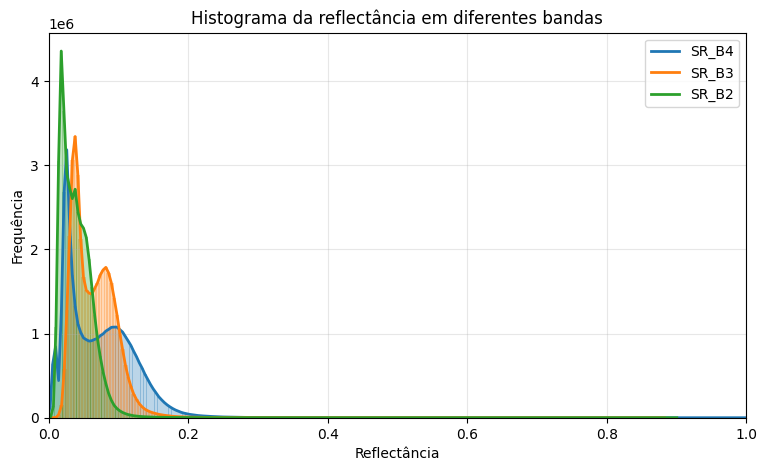

In [50]:
histograma = imagem.reduceRegion(
    reducer=ee.Reducer.histogram(maxBuckets=2**9, minBucketWidth=0.001), maxPixels=1e9
).getInfo()

fig, ax = plt.subplots(figsize=(9, 5))

for i, banda in enumerate(["SR_B4", "SR_B3", "SR_B2"]):
    frequencias = histograma[banda]["histogram"]
    bins = histograma[banda]["bucketMeans"]

    ax.bar(bins, frequencias, width=bins[1] - bins[0], alpha=0.3)
    ax.plot(bins, frequencias, linewidth=2, label=banda)
    ax.set_title(f"Histograma da reflectância em diferentes bandas")
    ax.set_xlabel("Reflectância")
    ax.set_ylabel("Frequência")
    ax.set_xlim([0, 1])

plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")
plt.show()

Utiliza as 3 bandas principais (vermelho, verde e azul) para visualizar a imagem e visualiza o mapa


Dessa vez seremos mais ousados... Você deverá selecionar um polígono no mapa do `geemap` e extrair as coordenadas do polígono para utilizarmos como região de interesse (ROI) para a extração da imagem.

Escolha uma região que seja coberta predominantemente por vegetação.
Regiões muito grandes podem deixar o processamento bastante lento, então tente escolher uma região de tamanho moderado.


In [80]:
imagem_vis = {
    "min": 0.0,
    "max": 0.3,
}

my_map = geemap.Map(center=[lat, lon], zoom=10)

my_map.add_layer(imagem.select(["SR_B4", "SR_B3", "SR_B2"]), {"bands": ["SR_B4", 'SR_B3', 'SR_B2'],  'min': '0', 'max': '0.3'}, "Landsat9")

my_map

Map(center=[-23.5546721, -46.7318389], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

In [83]:
polygon = my_map.draw_last_feature
my_map.remove_last_feature

polygon.getInfo()

{'type': 'Feature',
 'geometry': {'geodesic': False,
  'type': 'Polygon',
  'coordinates': [[[-46.980286, -23.489698],
    [-46.977539, -23.566505],
    [-46.873169, -23.575316],
    [-46.880035, -23.477103],
    [-46.980286, -23.489698]]]},
 'properties': {}}

Corta a imagem para apenas o polígono selecionado e visualiza o mapa


In [84]:
clipped = imagem.clip(polygon)
my_map.addLayer(clipped, imagem_vis, "Landsat9")
my_map

Map(bottom=149029.0, center=[-23.5546721, -46.7318389], controls=(WidgetControl(options=['position', 'transpar…

### Cálculo do NDVI


Vamos realizar algumas operações aritméticas para calcular o NDVI da imagem.

Primeiramente deve-se extrair as bandas do NIR e do vermelho e colocá-las em variáveis separadas.


In [85]:
# Veja na documentação o significado de cada banda
imagem_banda_nir = clipped.select("SR_B5")  # Near Infrared (NIR)
imagem_banda_vermelho = clipped.select("SR_B4")  # Red

Adicionar uma banda NDVI à imagem.
A fórmula do NDVI primeiro faz a diferença entre os valores da banda NIR e da banda do vermelho visível, depois o valor resultante é dividido pela soma das mesmas duas bandas.


In [86]:
clipped = clipped.addBands(
    imagem_banda_nir.subtract(imagem_banda_vermelho)
    .divide(imagem_banda_nir.add(imagem_banda_vermelho))
    .rename("NDVI"),  # NDVI será o nome da nova banda
    ["NDVI"],
)

Podemos conferir que no objeto `clipped` foi adicionada uma banda NDVI.


In [87]:
clipped

Adicionar o NDVI como um _layer_ no mapa


In [88]:
my_map.addLayer(clipped, {"bands": ["NDVI"], "min": -1, "max": 1}, "NDVI")

Visualizar o mapa novamente


In [81]:
my_map

Map(bottom=149029.0, center=[-23.5546721, -46.7318389], controls=(WidgetControl(options=['position', 'transpar…

### Execução do k-means


Há duas maneiras de se executar o k-means junto do GEE:

1. Uma delas está dentro de `ee.Algorithms`.
2. A outra é baseada na implementação do pacote WEKA dentro dos algoritmos da classe `ee.Clusterer`.

Vamos trabalhar com a segunda opção por enquanto, e depois podemos experimentar a primeira.


In [89]:
escala = 30  # 30 metros, ver descrição da coleção de imagens
bandas = ee.List(["SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"])

roi = clipped.select(bandas)  # Region of interest
roi

Primeiramente, vamos selecionar uma amostra de pixels com o método `sample()` chamado a partir da imagem que será classificada, que neste caso será a imagem `clipped`


In [90]:
# Selecionar uma amostra para executar o k-means
amostra_treinamento = roi.sample(
    region=roi.geometry(),  # redundante fazer isso, mas é para ensinar que é possível selecionar uma região menor
    scale=escala,
    numPixels=5000,
)

O resultado deve ser uma FeatureCollection com `numPixels` amostras.


In [91]:
amostra_treinamento
# TODO: acho que seria possível criar um pd.Dataframe com os dados da amostra abaixo,
# Isso facilitaria bastante a fazer o k-means lá na frente, mas o desafio maior é como voltar para o ee.ImageCollection depois

Executando a clusterização de k-means


In [92]:
k = 5  # número de clusters (altere se quiser testar diferentes valores)
clusters_imagem = ee.Clusterer.wekaKMeans(k).train(amostra_treinamento)

In [93]:
clusters_imagem

Agora classificamos os pixels de acordo com o resultado do k-means


In [75]:
# Classificando os pixels de acordo com o resultado do k-means da amostra
imagem_classificada_weka = roi.cluster(clusters_imagem)

In [76]:
imagem_classificada_weka

Vamos adicionar a nova imagem ao mapa para visualizarmos o resultado da classificação


In [77]:
# Adicionando a imagem classificada no mapa do GEE
# Vamos colorir aleatoriamente, mas você pode alterar as cores depois
my_map.addLayer(imagem_classificada_weka.randomVisualizer(), {}, "k-means")

Visualizar o mapa novamente


In [78]:
my_map

Map(bottom=149030.0, center=[-23.556119530236206, -46.731376647949226], controls=(WidgetControl(options=['posi…

TypeError: '<' not supported between instances of 'str' and 'int'

TypeError: '<' not supported between instances of 'str' and 'int'

TypeError: '<' not supported between instances of 'str' and 'int'

## Indo além


### Seleção de número de clusters ótimo


Vamos tentar encontrar, de forma programática, o número de clusters ótimo para a classificação.
Para tanto, precisamos rodar o k-means para diferentes valores de k e calcular o erro quadrático médio (MSE) para cada um deles.


Antes de mais nada, vamos criar uma função que realiza o k-means dado um número de clusters, a amostra de treinamento e uma imagem.


In [ ]:
def executa_kmeans(k: int, amostra: ee.FeatureCollection, img: ee.Image):
    """Executa o k-means na imagem 'img' com 'k' clusters, usando 'amostra'
    como amostra de treinamento."""
    # Initialization method to use.0 = random, 1 = k-means++, 2 = canopy, 3 = farthest first.
    return img.cluster(
        ee.Clusterer.wekaKMeans(nClusters=k, init=1, fast=True).train(amostra)
    )

Agora vamos para a parte mais legal: uma função para calcular a soma dos quadrados das distâncias dos pixels para o centroide do cluster ao qual ele pertence. Essa função é chamada de soma dos quadrados dentro do cluster (within cluster sum of squares, ou WCSS).


In [ ]:
def wcss(img_kmeans):
    """
    Esta função calcula a soma dos quadrados intra-clusters (Within Cluster Sum of Squares)
    para cada imagem clusterizada. Créditos: Leonardo Godoy
    """
    img_kmeans = ee.Image(img_kmeans)

    # Encontra o ID de cluster máximo na imagem
    max_id_cluster = img_kmeans.reduceRegion(
        reducer=ee.Reducer.max(), maxPixels=1e12, bestEffort=False
    )

    min_id_cluster = img_kmeans.reduceRegion(
        reducer=ee.Reducer.min(), maxPixels=1e12, bestEffort=False
    )

    # Cria uma lista de IDs de cluster
    lista_id_clusters = ee.List.sequence(
        min_id_cluster.get("cluster"), max_id_cluster.get("cluster")
    )

    # Função para calcular a diferença quadrática para um cluster
    def calcula_diff_quad_cluster(id_cluster):
        # Isola os pixels pertencentes ao cluster atual
        pixels_cluster = roi.mask(img_kmeans.eq(ee.Number(id_cluster).toInt()))

        # Calcula a média dos pixels do cluster
        media_pixels_cluster = pixels_cluster.reduceRegion(
            ee.Reducer.mean(), maxPixels=1e12, bestEffort=False
        )

        # Calcula a diferença quadrática
        diff_quad = pixels_cluster.subtract(media_pixels_cluster.toImage()).pow(2)

        # Soma a diferença quadrática sobre todas as bandas
        diff_quad_soma_bandas = diff_quad.reduceRegion(
            ee.Reducer.sum(), maxPixels=1e12, bestEffort=False
        )

        # Retorna a soma das diferenças quadráticas para todas as bandas
        return diff_quad_soma_bandas.values().reduce(ee.Reducer.sum())

    # Mapeia a função sobre a lista de IDs de cluster e reduz os resultados
    soma_wcss = lista_id_clusters.map(calcula_diff_quad_cluster).reduce(
        reducer=ee.Reducer.sum()
    )
    value = soma_wcss.getInfo()
    print(f"\t>>> WCSS: {value:.2f}")
    return value

Perfeito, agora vamos iterar sobre uma lista de valores de k, fazer o agrupamento e calcular o WCSS para cada um deles.


In [ ]:
# TODO: código está bastante lento, mas não consegui fazer funcionar usando map (erro 429 na API do GEE)

# Gera lista com uma sequência dos números de cluster
numero_clusters = range(2, 15, 1)  # start, stop, step

# Lista para armazenar os resultados
k_values = []  # Lista para armazenar os valores de k
wcss_values = []  # Lista para armazenar os valores WCSS

# Loop para aplicar k-means com diferentes números de clusters
# Obs.: Existem várias informações de tempo aqui, mas isso é só para debug
for k in numero_clusters:
    print(f"Executando k-means com k = {float(k):2.0f}")
    start_time = time.time()  # Captura o tempo de início da iteração

    img = executa_kmeans(k, amostra_treinamento, roi)
    k_values.append(k)
    wcss_values.append(wcss(img))

    # Calcula o tempo e imprime no console
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\tK-means concluído em {elapsed_time:.2f} s.\n")

Plotar o gráfico de MSE para cada valor de k, e identificar o ponto de inflexão, que é o número de clusters ótimo.


In [ ]:
# Plota o gráfico WCSS
from scipy.optimize import curve_fit
import numpy as np


# Definindo a forma da função exponencial decrescente.
def exp_decreasing(x, a, b, c):
    return a * np.exp(-b * x) + c


k_values = np.array(k_values)
wcss_values = np.array(wcss_values)


# Ajustando a função aos dados. popt são os valores otimizados para os parâmetros da função (a, b e c)
popt, _ = curve_fit(
    exp_decreasing, k_values, wcss_values, p0=(30000, 0.1, 18000)
)  # p0 é o palpite inicial para os valores dos parâmetros
# Usando os parâmetros otimizados para prever y com base em x
y_pred = exp_decreasing(k_values, *popt)
# Imprimindo os parâmetros otimizados
print("Parâmetros otimizados: a =", popt[0], "b =", popt[1], "c =", popt[2])
plt.plot(k_values, y_pred, "r-", label="Ajuste exponencial")

plt.plot(k_values[:], wcss_values, "bx-", label="WCSS")
plt.title("Método do Cotovelo para K-Means Clustering")
plt.xlabel("Número de clusters - k")
plt.ylabel("WCSS")
plt.xlim(xmin=1.8)
plt.grid()
plt.legend()
plt.show()

A partir do gráfico acima, podemos analisar visualmente qual o número ideal de clusters, que será o ponto de inflexão da curva.


### Alternativa para execução do k-means no GEE


In [ ]:
imagem_classificada = ee.Algorithms.Image.Segmentation.KMeans(
    image=roi, numClusters=5, uniqueLabels=False
)

In [ ]:
my_map.addLayer(imagem_classificada.randomVisualizer(), {}, "k-means3")
my_map

## Atividade
